# Plant Disease Detection


## Approach
Convolutional Neural Network (CNN) methodologies were employed to create an AI approach for detecting diseases in plants through leaf images. The neural network model or architecture was formulated using the Keras API and implemented using Python in conjunction with TensorFlow.

### Imports

In [6]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 21.8 MB/s eta 0:00:00


In [7]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os
import tensorflow as tf
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import keras
from keras.utils import to_categorical
from keras import regularizers


from keras import datasets, models, layers, optimizers, regularizers, callbacks
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from keras.optimizers import SGD, Adam
from keras.metrics import Recall, Precision

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import visualkeras
from tensorflow.keras.models import load_model


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [8]:
## USE ONLY IN GOOGLE COLAB

#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
#data directories
plants_dir = "/content/drive/MyDrive/Plant_split/plant_split"
train_dir = "/content/drive/MyDrive/Plant_split/plant_split/train"
test_dir = "/content/drive/MyDrive/Plant_split/plant_split/test"
val_dir = "/content/drive/MyDrive/Plant_split/plant_split/val"

In [10]:
#define parameters
epochs = 25
steps = 100
learning_rate = 1e-4
batch_size = 32
width = 256
height = 256
depth = 3

## Image Generation
 The code below prepares generators for training, validation, and test datasets stored in specified directories. The training data generator applies rescaling, shear transformations, zoom transformations, and horizontal flips to augment the images, while the validation and test data generators only rescale the images. The generators are configured to work with categorical data, assuming there are multiple classes, and the batch size is set to 32 for each generator.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for training data with rescaling
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,  #normalize
    shear_range = 0.2,   # shear transformation
    zoom_range = 0.2,    # zoom
    horizontal_flip = True  # horizontal flip
)

# imagedatagenerator for val and test data
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# paths
train_dir = "/content/drive/MyDrive/Plant_split/plant_split/train"
test_dir = "/content/drive/MyDrive/Plant_split/plant_split/test"
val_dir = "/content/drive/MyDrive/Plant_split/plant_split/val"

# generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (height, width),
    batch_size=  32,
    class_mode = 'categorical',
    shuffle = True
)
val_generator = val_test_datagen.flow_from_directory(
   val_dir,
    target_size = (height, width),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size = (height, width),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 44358 images belonging to 2 classes.
Found 8316 images belonging to 2 classes.
Found 2772 images belonging to 2 classes.


In [13]:
#checking labels

train_generator.class_indices

{'disease': 0, 'healthy': 1}

In [14]:
#swap
train_generator.class_indices = {'healthy': 0, 'disease': 1}
test_generator.class_indices = {'healthy': 0, 'disease': 1}
val_generator.class_indices = {'healthy': 0, 'disease': 1}

In [15]:
#check
val_generator.class_indices

{'healthy': 0, 'disease': 1}

## Build Model

The model consists of multiple convolutional layers to extract hierarchical features from input images, followed by fully connected layers for classification. Dropout is incorporated for regularization, and the softmax activation in the output layer allows for multi-class classification.The model is configured with the Adam optimizer, using a learning rate of 1e-4. The chosen learning rate strikes a balance between convergence speed and stability. The categorical crossentropy loss functionis selected for multi-class classification tasks. The accuracy metric is chosen for evaluation, calculating the ratio of correctly classified samples to the total.

In [16]:
#model function
def create_model():
  model = keras.models.Sequential([
      #conv layers
      keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = (height, width, depth)),
      keras.layers.MaxPooling2D((2, 2)),
      keras.layers.Conv2D(64, (3, 3), activation='relu'),
      keras.layers.MaxPooling2D((2, 2)),
      keras.layers.Conv2D(128, (3, 3), activation='relu'),
      keras.layers.MaxPooling2D((2, 2)),

      #flatten
      keras.layers.Flatten(),

      #dropout for regularization
      keras.layers.Dropout(0.5),

      #dense layers
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dropout(0.5),

      #output
      keras.layers.Dense(2, activation='softmax'),
  ])

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-4),
                loss = keras.losses.categorical_crossentropy,
                metrics = ['accuracy'])


  return model


In [17]:
#let's check it out!
model = create_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

## Fit Model

In [28]:
#fit
history = model.fit(train_generator, validation_data = val_generator, epochs = 25)

Epoch 1/25
1387/1387 [==============================] - 20753s 15s/step - loss: 0.1768 - accuracy: 0.9327 - val_loss: 0.6444 - val_accuracy: 0.7122
Epoch 2/25
1387/1387 [==============================] - 639s 461ms/step - loss: 0.1160 - accuracy: 0.9587 - val_loss: 0.9287 - val_accuracy: 0.6556
Epoch 3/25
1387/1387 [==============================] - 629s 453ms/step - loss: 0.0807 - accuracy: 0.9713 - val_loss: 0.9183 - val_accuracy: 0.7140
Epoch 4/25
1387/1387 [==============================] - 632s 456ms/step - loss: 0.0614 - accuracy: 0.9783 - val_loss: 0.8697 - val_accuracy: 0.7459
Epoch 5/25
1387/1387 [==============================] - 619s 446ms/step - loss: 0.0511 - accuracy: 0.9821 - val_loss: 0.6696 - val_accuracy: 0.7878
Epoch 6/25
1387/1387 [==============================] - 596s 430ms/step - loss: 0.0445 - accuracy: 0.9849 - val_loss: 0.6244 - val_accuracy: 0.8039
Epoch 7/25
1387/1387 [==============================] - 594s 428ms/step - loss: 0.0380 - accuracy: 0.9878 - val_

In [29]:
#FANTASTIC!
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100}")

87/87 [==============================] - 1584s 18s/step - loss: 0.4017 - accuracy: 0.9026
Test Accuracy: 90.2597427368164


## Checking out validation and loss plots

In [19]:
# plot validation loss and accuracy

history_dict = history.history
loss = history_dict['loss']
acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)
epochs_list = list(epochs)

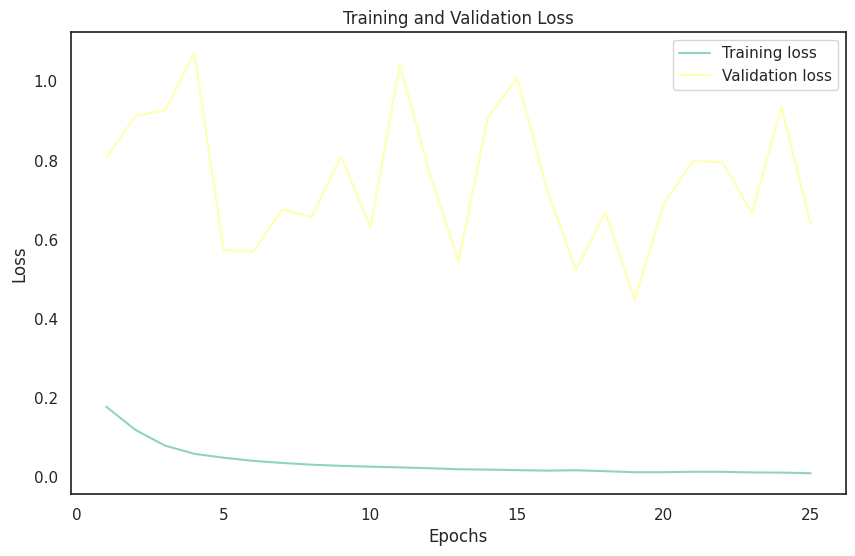

In [ ]:
#df
model_loss = pd.DataFrame({
    'Epochs': epochs_list * 2,  # Repeat epochs for both training and validation data
    'Loss': loss + val_loss,
    'Type': ['Training loss'] * len(epochs_list) + ['Validation loss'] * len(epochs_list)
})

# Plot data
sns.set(style="white")
sns.set_palette("Set3")

plt.figure(figsize=(10, 6))
model_loss_plot = sns.lineplot(x='Epochs', y='Loss', hue='Type', data=model_loss)

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

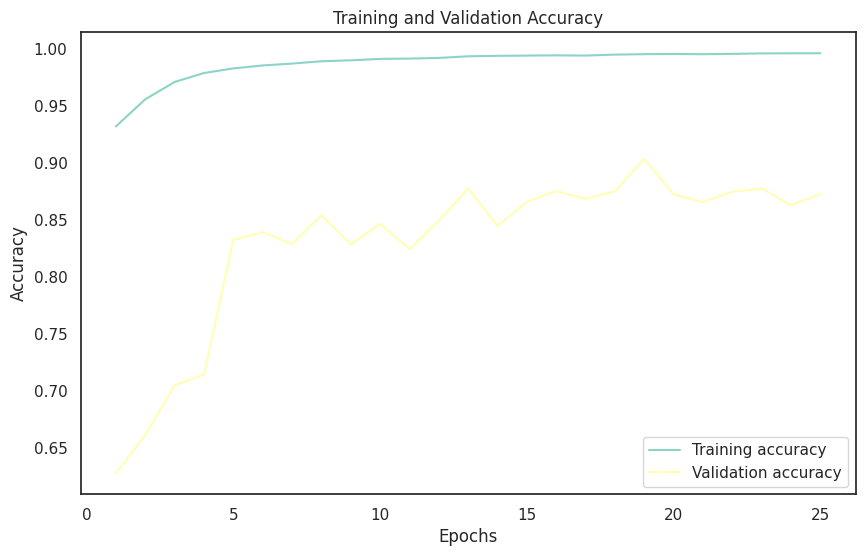

In [ ]:
#df
model_acc = pd.DataFrame({
    'Epochs': epochs_list * 2,  # Repeat epochs for both training and validation data
    'Accuracy': acc + val_acc,
    'Type': ['Training accuracy'] * len(epochs) + ['Validation accuracy'] * len(epochs)
})

# Use Seaborn to plot the data
sns.set(style = "white")
sns.set_palette("Set3")

plt.figure(figsize=(10, 6))
acc_plot = sns.lineplot(x='Epochs', y='Accuracy', hue='Type', data=model_acc)

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Save model

In [20]:
#save model
model.save('plant_binaryI.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
# load model for visual
model = load_model('plant_binaryI.h5')

# visualize the model architecture and save
visualkeras.layered_view(model, to_file = '/content/drive/MyDrive/plant_binary_model.png').show()